ver: Variables instrumentales, métodos de discontinuidad de regresión y variables instrumentales locales

**Estadística vs. Causal**: Incluso con una cantidad infinita de datos, a veces no podemos calcular algunas cantidades causales. Por el contrario, gran parte de las estadísticas se trata de abordar la incertidumbre en muestras finitas. Cuando se dan datos infinitos, no hay incertidumbre. Sin embargo, la asociación, un concepto estadístico, no es causalidad. Hay más trabajo por hacer en la inferencia causal, incluso después de comenzar con datos infinitos. Esta es la distinción principal que motiva la inferencia causal.

**Identificación frente a estimación**: la identificación de los efectos causales es exclusiva de la inferencia causal. Es el problema que queda por resolver, incluso cuando tenemos datos infinitos. Sin embargo, la inferencia causal también comparte estimación con la estadística tradicional y el aprendizaje automático.

**Intervencional vs Observacional**: Si podemos intervenir/experimentar,
la identificación de los efectos causales es relativamente fácil. Esto se debe simplemente a que podemos tomar la acción cuyo efecto causal queremos medir y simplemente medir el efecto después de tomar esa acción. Los datos de observación es donde se vuelve más complicado porque casi siempre se introduce confusión (ruido) en los datos.

¿Por qué nuestras mentes estarían tan "cableadas" para pensar en relaciones causales por encima de las meramente correlacionales? Una buena razón sería que _las correlaciones que son causales son más estables en el tiempo y ante cambios en el entorno_. En palabras de Pearl, traducidas de su importante libro _Causality_,

> ... las relaciones causales son _ontológicas_, al describir vínculos físicos objetivos de nuestro mundo, mientras que las relaciones probabilísticas son _epistémicas_, reflejando lo que sabemos o creemos sobre el mundo.

Tiene sentido pues que la capacidad de _generalizar_ de un modelo de inteligencia artificial y la capacidad de _transferir_ el aprendizaje a una tarea nueva dependan de la capacidad del modelo de aislar los _mecanismos causales_ correctos (o más probables) a partir de los datos. Sin proponer que algunas correlaciones corresponden a mecanismos causales, mientras que otras no, es imposible saber qué correlaciones se mantendrían y cuáles serían destruidas al modificarse algún factor del entorno generador de los datos.

Actualmente hay muchísimo interés en las posibilidades de combinar o aumentar las capacidades de los modelos de Machine Learning con métodos de inferencia causal

### Causalidad no es correlación

(Mejor dicho, _correlación no implica causalidad_.)
Las _correlaciones espurias_ nos muestran que dos variables pueden aparecer asociadas, es decir que "se mueven conjuntamente", en este caso en el tiempo, incluso cuando lo más plausible es que no tengan absolutamente nada que ver.

También pueden utilizarse para enfatizar que la correlación presente en los datos puede ser altamente _no lineal_, por lo cual una medida como la correlación de Pearson, que mide correlación _lineal_, puede resultar engañosa. Pero hay medidas de correlación más fidedignas en el caso no lineal (como por ejemplo, la _entropía relativa_, también llamada _divergencia de Kullback-Leibler_).

Detrás de todas estas nociones de correlación (o "asociación", como se dice a veces para distinguir de la correlación puramente lineal) hay un concepto fundamental, que es el de la **dependencia probabilística**. Dadas dos variables aleatorias $X, Y$, decimos que son **probabilísticamente independientes** si su distribución de probabilidad conjunta se factoriza como $p(X, Y) = p(X) p(Y)$. Equivalentemente, condicionar sobre una de las dos variables no afecta la distribución de valores de la otra:

$$ p(X | Y=y) = p(X) $$
$$ p(Y | X=x) = p(Y) $$

Vamos a usar una notación especial para esta situación de independencia entre $X$ e $Y$: 

$$\renewcommand{\indep}{\perp \!\!\! \perp} X \indep Y$$

También usaremos fuertemente el concepto de **independencia condicional**: $X$ es independiente de $Y$ _dado_ $Z$ (escribimos $X \indep Y | Z$) si $p(X, Y | Z) = p(X | Z) p(Y | Z)$. Volveremos sobre esto en la Clase 2, pero por ahora es importante que **cuando hablamos de correlación, no nos referimos solamente a la correlación lineal** sino que **dos variables $X$, $Y$ están correlacionadas en alguna medida siempre que $p(X, Y) \neq p(X) p(Y)$**.

---
Dijimos que correlación no implica causalidad, pero por el contrario, **si veo correlación, es más probable que haya causalidad que si no observo nada**. De hecho el filósofo Hans Reichenbach formuló a mediados del Siglo XX el [_Principio de la Causa Común_](https://plato.stanford.edu/entries/physics-Rpcc/), que lleva su nombre, según el cual **dadas dos variables correlacionadas, o bien una es causa de la otra, o bien al revés, o bien ambas tienen una causa común**. Es decir que **la correlación es nuestra herramienta para detectar causalidad, y trataremos de cómo _identificar_ cuándo correlación _sí_ implica causalidad.**

Pero entonces ¿Qué podemos decir sobre lo que _sí_ es la causalidad?


---

# Parte II: Marco conceptual: resultados potenciales (o _potential outcomes_)

Este marco trata de responder a la pregunta de si "A" causa "B" a partir de un contrafáctico: comparar "B dado A" con "B dado no A". La pregunta usual que uno se suele hacer.

Vamos a introducir algunos conceptos que son parte del modelo causal de Neyman-Rubin. 

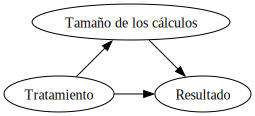

In [1]:
#@title {display-mode: "form"}
from graphviz import Digraph
from IPython.display import display

#Especificamos engine='neato' para poder usar argumento `pos` en nodos
dot = Digraph(engine='neato')
dot.node('T', 'Tratamiento', pos='1,1!')
dot.node('Y', 'Resultado', pos='3,1!')
dot.node('X', 'Tamaño de los cálculos', pos='2,2!')
dot.edges(['TY', 'XY', 'TX'])
dot

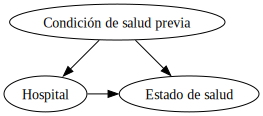

In [2]:
#@title {display-mode: "form"} 
from graphviz import Digraph
from IPython.display import display

#Especificamos engine='neato' para poder usar argumento `pos` en nodos
dot = Digraph(engine='neato')
dot.node('T', 'Hospital', pos='1,1!')
dot.node('Y', 'Estado de salud', pos='3,1!')
dot.node('X', 'Condición de salud previa', pos='2,2!')
dot.edges(['TY', 'XY', 'XT'])
dot

### Confusores y sesgos 

* Decimos que la "condición de salud" previa es un **confusor**. 
  * Una variable que está correlacionada tanto con el tratamiento $T_i$ (ir al hospital) como con el resultado $Y_i$ (el estado de salud posterior)
  * Si no la tomamos en cuenta, confundimos el efecto que queremos medir, la visita al hospital (la atención médica y otros servicios recibidos allí) con el confusor
* Decimos que cuando comparamos la salud promedio observada entre quienes fueron al hospital y quienes no, además del **efecto causal** de la visita al hospital, tenemos un **sesgo de selección**: las personas que "se autoseleccionan" para ir a hospital son distintas de las que no van. 
* **No** estamos cumpliendo con la comparación **_ceteris paribus_**: las circunstancias de un grupo (condición mala de salud previa), no son iguales a las del otro (condiciones buenas de salud previa)

* Comparar al grupo de personas que va al hospital con el grupo de personas que no va no sirve para responder nuestra pregunta causal, contrafáctica: ¿una persona que sí fue, está mejor que si no hubiera ido? (es decir, nuestra pregunta por el ITE, o por el ATE)

* Entonces, el grupo de personas que no va al hospital **no es un buen contrafáctico** de las personas que sí van al hospital


Como tenemos el DeLorean, podemos **observar y comparar ambos resultados potenciales**. El efecto individual de tratamiento (**ITE**, por _individual treatment effect_) para Marty será la diferencia en el resultado de salud cuando Marty va al hospital y el resultado de salud cuando Marty no va al hospital:


\begin{equation}
 ITE_{Marty} =  \underbrace{Y_{Marty}(T_{Marty} = 1)}_{\substack{\text{ Resultado observado} \\ \text{dado que fue al hospital}}}
- \underbrace{Y_{Marty}(T_{Marty} = 0)}_{\substack{\text{ Resultado observado} \\ \text{dado que NO fue al hospital}}} = Y(1) - Y(0)
\end{equation}

En particular, a la media de los ITE la llamamos efecto medio de tratamiento (**ATE**, por _Average Treatment Effect_). 

_La diferencia de medias entre los resultados observados de grupos tratados y no tratados a veces se la llama "diferencia asociacional"_

* ATE: $E[Y(1) - Y(0)] = E[Y(1)] - E[Y(0)$

* Diferencia asociacional: $E[(Y|T=1)] - E[(Y|T=0)]$


Podemos descomponer la diferencia asociacional (observada) en dos componentes no observables:

* El **TOT**, por "Treatment on the Treated", que es el ATE (compara los resultados potenciales $Y_i(0)$ e $Y_i(1)$) pero solamente para el grupo de tratados (condiciona en $T_i=1$), en este caso para los que van al hospital. Son las diferencias en el resultado **atribuibles al tratamiento**. 
_Notas sobre el TOT: (a) definiendo el tratamiento inverso ($T_i=1$ como no ir al hospital) podríamos encontrar el ATE para el grupo quienes no van al hospital. Pero en general nos interesa el efecto del tratamiento para el grupo de que sean tratados. (b) Muchas veces se lo llama directamente ATE, pero debemos recordar que es el ATE para solamente los tratados_

* El **sesgo de selección** es la diferencia de los resultados potenciales de NO recibir tratamiento entre el grupo de tratados y el grupo de no tratados. Es decir, las diferencias que de todos modos existirían en el resultado de tratados y no tratados aún si no hubieran recibido el tratamiento. Por lo tanto, son las diferencias en el resultado que **no son atribuibles al tratamiento**. En nuestro ejemplo, son las diferencias que seguirían existiendo entre quienes fueron y quienes no fueron al hospital si ninguno hubiera ido al hospital.

Por lo tanto, al comparar las medias de quienes van al hospital y quienes no van, estamos confundiendo el efecto de ir al hospital con otras diferencias que hay entre quienes van y quienes no van. El objetivo, entonces, será eliminar el sesgo de selección para poder aproximar el efecto de tratamiento.


Eliminar el sesgo de selección implica hacer una comparación _ceteris paribus_, como si no hubiera diferencias entre los que van y no van al hospital, como si estuviéramos comparando a la misma persona que viajó al pasado y volvió al futuro. Y **las comparaciones que se establecen en condiciones *ceteris paribus* admiten una interpretación causal**, no tienen sesgo de selección.

## Supuestos para aproximar bien el efecto de tratamiento

Vimos que APROXIMAR BIEN EL TOT == eliminar el sesgo de selección o los confusores == conseguir un **buen contrafáctico** del hecho de ir al hospital. Conseguir un **buen contrafáctico** es aproximar el resultado potencial si los que fueron al hospital no hubieran ido.

Como no podemos comparar al mismo individuo en dos mundos paralelos, la solución estadística es estimar el efecto causal observando a individuos distintos y comparando los promedios de esos grupos. Para que la comparación entre grupos identifique el efecto causal, deben cumplirse los siguientes supuestos:


El supuesto estrella es el **supuesto de independencia:**  Y(0), el resultado potencial de no haber recibido tratamiento, es independiente de ser o no tratado. Formalmente, esto significa que
$E [Y_i(0) | T_i = 1] = [Y_i(0) | T_i = 0] = E[Y_i(0)]  \rightarrow \text{Sesgo de seleccion} = 0$ .

Además, los siguientes supuestos:
* Exchangeability: el efecto estimado no depende de quiénes reciban el tratamiento (de sus otras características), podríamos intercambiar las personas tratadas con las no tratadas y el resultado no se ve afectado. 
* SUTVA (Stable Unit Treatment Value Assumption), que agrupa dos supuestos:
  * No interferencia: el outcome potencial de un individuo no puede verse afectado por el hecho de que otro individuo sea tratado, por ejemplo, no puede haber "efectos derrame" o "spillovers", como sucede con las vacunas. 
  * Homogeneidad en el tratamiento: todos los tratados reciben lo mismo, hay una sola versión de cada tratamiento, no hay variaciones ocultas en el tratamiento y está bien claro y definido qué significa ser tratado. 


Estamos comparando en condiciones _ceteris paribus_, lo único que distingue a los grupos es el hecho de haber recibido tratamiento, y tenemos un grupo de control es un _buen contrafáctico_ del grupo de tratamiento. Las estrategias que veremos a lo largo del curso se esfuerzan por construir ese contrafáctico creíble. También, la idea es entrenarnos en darnos cuenta cuándo es probable que alguno de estos supuestos no se esté cumpliendo y estemos identificando mal el efecto causal. 

¿Cómo podemos verificar que se cumple el supuesto de independencia?
**Respuesta**. Nunca podremos _verificar_ que se cumple el supuesto de independencia (¡por eso es un supuesto!) porque para el grupo de tratados jamás podremos observar el efecto potencial de no haber sido tratado. Los argumentos respecto de si se cumple o no siempre serán teóricos, no empíricos. A grandes rasgos hay dos formas de tratar de que el supuesto de independencia se cumpla y creíblemente lograr comparar entre "grupos que hubieran sido idénticos" de no haber existido tratamiento. Esas dos grandes formas son: (1) asignación aleatoria del tratamiento, (2) controlar por los posibles confusores, es decir, las variables que son diferentes entre los grupos y pueden afectar el resultado.


#### (1) Experimentos
**Alto ahí.** ¿Por qué pensás que los experimentos son útiles para identificar relaciones causales?

Una forma de conseguir que se cumpla el supuesto de independencia es **asignar aleatoriamente el tratamiento**. De esa manera, estar expuesto a tratamiento o control, es independiente de cualquier otra variable. En particular, el tratamiento no estará correlacionado con el resultado potencial de no haber sido tratado. O lo que es lo mismo, los tratados y los no tratados hubieran sido idénticos de no haber sido por el tratamiento.

Lo que podemos verificar al hacer un experimento es que el tratamiento no esté correlacionado con de las características pre-tratamiento. Por lo tanto, lo único que diferenciará a los tratados de los no tratados será el hecho de recibir el tratamiento. No habrá sesgo de selección. 

Si la población es lo suficientemente grande, en promedio las características del grupo de control y las características del grupo de tratamiento serán las mismas (hay "balanceo de características").

#### (2) Controlar por confusores

Otra opción es controlar por todas aquellas características que diferencian al grupo de tratados y no tratados, y que podrían estar correlacionadas con el resultado. Condicional en dichas características, el resultado potencial de no recibir tratamiento debería ser el mismo para ambos grupos. 


Una variable **confusora**: es relevante para el resultado _y además_ está correlacionada con la variable de tratamiento. Si la omitimos, no podemos identificar correctamente el efecto causal de fumar en la salud. Aparece un **sesgo** y pareciera que fumar se asocia a tener una mayor salud. Se "confunde" el efecto propio de fumar en la salud con el hecho de que los fumadores en general son jóvenes y los jóvenes tienen mejor salud. pero no podemos saber qué parte de la diferencia en la salud promedio de fumadores y no fumadores es efectivamente atribuible al tratamiento (a fumar) y qué parte es atribuible al confusor (a que los fumadores son jóvenes). 


> _Las variables confusoras son aquellas que correlacionan tanto con el tratamiento como con el resultado. Esto hace que los no tratados no sean un buen contrafáctico para los tratados. Porque si los tratados tienen una característica más allá del tratamiento que los diferencia de los no tratados, y esa característica puede influir sobre la variable de resultado, no tenemos forma de distinguir que es el tratamiento y no esta otra variable la causa de los resultados diferentes que observemos. Si no controlamos por ella, la confundiremos con el tratamiento._


* Al experimentar, rompemos la relación de fumar con la edad. Los tratados y no tratados pasan a tener edades que en promedio son similares entre sí. Si ninguno fumara, en promedio los tratados y los no tratados tendrían la misma salud: el resultado potencial de no recibir tratamiento (de no fumar) es el mismo, se cumple el supuesto de independencia. 

* Controlar por la edad permite separar los efectos parciales de fumar y de la edad en la salud. Le "quita" a la variable $fumar$ la parte que afecta a la salud a través de la edad. O, lo que es lo mismo, permite comparar fumadores versus no fumadores entre grupos de la misma edad. Condicional en la edad, el resultado potencial de recibir tratamiento (de no fumar) es el mismo, se cumple el supuesto de independencia. 

# Identificar versus estimar

Es importante distinguir entre algunos conceptos:

- **Estimando y estimador**. El _estimando_ es la cantidad que queremos estimar, que en casos paramétricos suele ser alguno de los parámetros poblacionales (por ejemplo $\beta_1$). En cambio, el _estimador_ es una función de los datos (es decir un _estadístico_) que nos permite aproximarnos al valor real (por ejemplo $\hat{\beta}_1$, el valor calculado por cuadrados mínimos, estima $\beta_1$).

Hay dos tipos de estimandos:
- **Estimando causal**: es un estimando que involucra contrafácticos y por lo tanto no es inmediatamente calculable (involucra "datos faltantes" imposibles de medir). El que venimos viendo fundamentalmente es el ATE, $E[Y(1)] - E[Y(0)]$
- **Estimando estadístico**: es un estimando que no involucra contrafácticos y por lo tanto puede ser calculado a partir de los datos sobre lo que realmente ocurrió (independientemente de si tenemos acceso o no a esos datos).

Y esto es fundamental para distinguir claramente dos etapas del análisis causal:

- **Identificación** es el proceso de utilizar hipótesis causales para transformar un estimando causal en un estimando estadístico equivalente.
- **Estimación**: es el proceso de elegir y calcular un estimador para nuestro estimando elegido previamente.

En nuestra simulación, al omitir la variable edad, la _estimación_ de $\beta_1$ sí capta correctamente la **correlación** entre tratamiento y resultado: en efecto, ¡los fumadores suelen tener mejor salud! Pero que no sería correcto darle a esa correlación una interpretación causal. Hay una parte de esa correlación que es espuria: se debe al hecho de que son los jóvenes los que fuman más, y a su vez los jóvenes tienen mejor salud. Confundimos el efecto de la edad en la salud con el efecto parcial que nos interesa realmente, el de fumar en sí. El error no está en la etapa de estimación per se, sino en la etapa de identificación: el _estimando_, aquello que nuestro método estadístico estima, no tiene una interretación causal, y por lo tanto tampoco la tiene nuestro estimador.

Así, podemos entender el proceso de análisis causal descrito hasta ahora como el siguiente _pipeline_ (cadena de procesos a ser realizados uno detrás del otro):

$$ {\sf Modelar} \to {\sf Identificar} \to {\sf Estimar} $$

# Causalidad, predecibilidad y explicabilidad

A medida que vayamos avanzando, la idea es que quede cada vez más claro por qué las siguientes herramientas de análisis **no hacen análisis causal** por más que muchas veces se diga que lo hacen.

- _Shap values_. Los valores SHAP (SHapley Additive exPlanations) son un método muy interesante para identificar qué aspectos del input de un modelo son los más informativos a la hora de explicar el resultado de predicción del mismo. Sin embargo esto no tiene mucho que ver con qué pasaría si alguna variable fuera intervenida a través de alguna decisión o cambio en el mundo real que genera los datos que sirven de input al modelo. Ver [aquí](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html).
  - Esto es un buen ejemplo de cómo _causalidad y explicabilidad son cosas diferentes_.
<center><img src="./imgs/shap.png" height="300" style="margin:auto"/></center>

  
- Análisis factorial y métodos como PCA (Principal Component Analysis): a grandes rasgos pasa lo mismo que con SHAP: se trata de encontrar combinaciones de las variables ("factores" o "componentes principales") que explican la variabilidad observada. Más allá de que potencialmente haya alguna hipótesis causal sobre la relación entre estos factores y las variables observadas, podemos decir que estos métodos no utilizan ideas de análisis causal tal como ha sido presentado aquí.
- Causalidad de Granger. En este caso se trata de determinar mediante un test estadístico si una serie de tiempo X (vista hasta tiempo $t$) puede ser utilizada para predecir el valor que _otra_ serie de tiempo Y adopta en el instante $t+1$. Por más que tenga "causalidad" en el nombre, hasta el mismo Granger admitió que no es tanto una medida de causalidad sino una medida de hasta qué punto X _pronostica_ a Y.

<center><img src="imgs/granger.png" height="250" style="margin:auto"/></center>

En el fondo, lo que ocurre métodos como estos permiten entender mejor la naturaleza de las **correlaciones** presentes en los datos (y cómo se relacionan con las predicciones de nuestros modelos), pero nunca abordan directamente la causalidad **porque nunca se meten con el razonamiento contrafáctico**. Así que recuerden:

- ¡Sin contrafácticos no hay causalidad!
- ¡Sin hipótesis causales, no hay conclusiones causales!

Este fue nuestro primer encuentro con un **grafo causal**.

Un **grafo** se define matemáticamente como un conjunto de nodos o *vértices*, y un conjunto de conexiones o *aristas* entre pares de nodos. En este caso, las aristas son dirigidas, porque **las relaciones causales son asimétricas** (¡a diferencia de las correlaciones!), y las dibujamos como flechas. De un lado tenemos las causas y del otro, los efectos. Más aún, dado que no permitimos que una variable sea causa de sí misma, en estos grafos no es posible partir de un nodo y, siguiendo las direcciones de las flechas, volver al mismo. Es decir que se trata de _grafos dirigidos acíclicos_ (_DAGs_).

En un grafo (o red) causal, los caminos representan **flujos de asociación**:

* $T$ está correlacionada con $Y$, pero _por dos razones diferentes_:
  1. Porque está correlacionada con $X$, que a su vez está correlacionada con $Y$ (patrón de relaciones que determina que $X$ sea variable confusora)
  2. Porque es _causa_ de $Y$
* **las flechas representan causalidad directa**, mientras que **los caminos siguiendo las flechas representan causalidad indirecta**.
* La fuente de asociación (1) es _no causal_, porque sigue un camino en el grafo que no respeta la dirección de las flechas ()
* La fuente de asociación (2) es _causal_, porque sigue un camino en el grafo que respeta la dirección de las flechas (el camino podría involucrar más de una flecha, pero mientras que siempre siga la dirección de las flechas va a ser un camino causal).

La idea entonces es que **al controlar por $X$ _bloqueamos_ el camino no causal de $T$ a $Y$** (lo que se llama un "camino _backdoor_"), **y la única asociación que nos queda es la que fluye por el otro camino, que sí es causal**. Esto lo vamos a formalizar mejor. 

Volviendo a la fórmula de ajuste de arriba, **nuestro objetivo será saber cómo conseguir ese conjunto de ajuste $W$ y eso va a depender de la forma particular que adopta el patrón de relaciones causales, codificado como un grafo.**

## 2. Queremos expresar estimandos causales en el formalismo gráfico

Los estimandos causales se pueden expresar, en vez de con potential outcomes, con la **_notación do_ de Pearl**. En vez de escribir $\E[Y(0)]$, vamos a escribir $\E[Y \mid do(T=0)]$, y en vez de escribir $\E[Y(1)]$, vamos a escribir $\E[Y \mid do(T=1)]$.

Esta notación nos provee una concepción matemática alternativa de los contrafácticos basada en el concepto de **_intervención_**, que está integrada con el formalismo de grafos. La idea es que así como podemos _condicionar_ sobre variables, también podemos _intervenir_ variables. **Las reglas de la "probabilidad intervenida" se suman a las reglas de la probabilidad condicional, ampliando la teoría de probabilidades clásica para poder abordar la causalidad**.

---

## Referencias

### Para repasar
- **Angrist & Pischke (2015), Dominar la econometría**. Capítulo 1 - Experimentos aleatorios.
- **Neal (2020), [Introduction to causal inference](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf)**. Capítulos 1 y 2 (en inglés)

### Para profundizar
- Causalidad y filosofía
  - Stanford Encyclopedia of Philosophy, [Counterfactual theories of causation](https://plato.stanford.edu/entries/causation-counterfactual/)
- Causalidad y econometría
  - El [artículo de prensa del premio Nobel de economía de 2021](https://www.nobelprize.org/prizes/economic-sciences/2021/press-release/) y los artículos que allí se citan (en inglés)
  - Imbens (2019), [Potential Outcome and Directed Acyclic Graph Approaches to Causality: Relevance for Empirical Practice in Economics](https://arxiv.org/abs/1907.07271)
  - Este video titulado [Machine Learning and Causal Inference for Policy Evaluation](https://www.youtube.com/watch?v=Yx6qXM_rfKQ) y este otro video titulado [Machine Learning and Causal Inference](https://www.youtube.com/watch?v=DixuYCsXFig&t=214s) de Susan Athey (en inglés)
  - Este video titulado [Econometrics is the original data science](https://www.youtube.com/watch?v=T24j8XTcpe0) de Joshua Angrist (en inglés)
- Causalidad e inteligencia artificial
  - Schölkopf et al (2021) [Towards Causal Representation Learning](https://arxiv.org/abs/2102.11107)
  - Zhao, Hastie (2021) [Causal interpretations of black-box models](https://www.tandfonline.com/doi/pdf/10.1080/07350015.2019.1624293)

In [5]:
# Instalar
%pip install linearmodels --quiet

# Importar

import pandas as pd
import numpy as np
import io

#from google.colab import files

import matplotlib.pyplot as plt
import graphviz as gr

import statsmodels.formula.api as smf
from linearmodels import IV2SLS  # módulo específico de variables instrumentales


Note: you may need to restart the kernel to use updated packages.


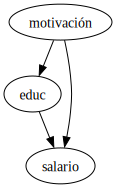

In [6]:
g = gr.Digraph()

g.edge("motivación", "educ")
g.edge("motivación", "salario")
g.edge("educ", "salario")
g

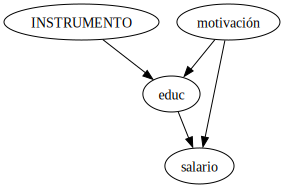

In [7]:
g = gr.Digraph()

g.edge("motivación", "educ")
g.edge("motivación", "salario")
g.edge("educ", "salario")
g.edge("INSTRUMENTO", "educ")
g

<center>
<img src="./imgs/img1_instrum.png" style="margin:auto" height=200/>
</center>

In [8]:
ak = pd.read_csv("https://storage.googleapis.com/humai-datasets/causalidad/ak91.txt")
ak .head()

,log_salario,educ,nacim_a,nacim_trim,nacim_estado
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


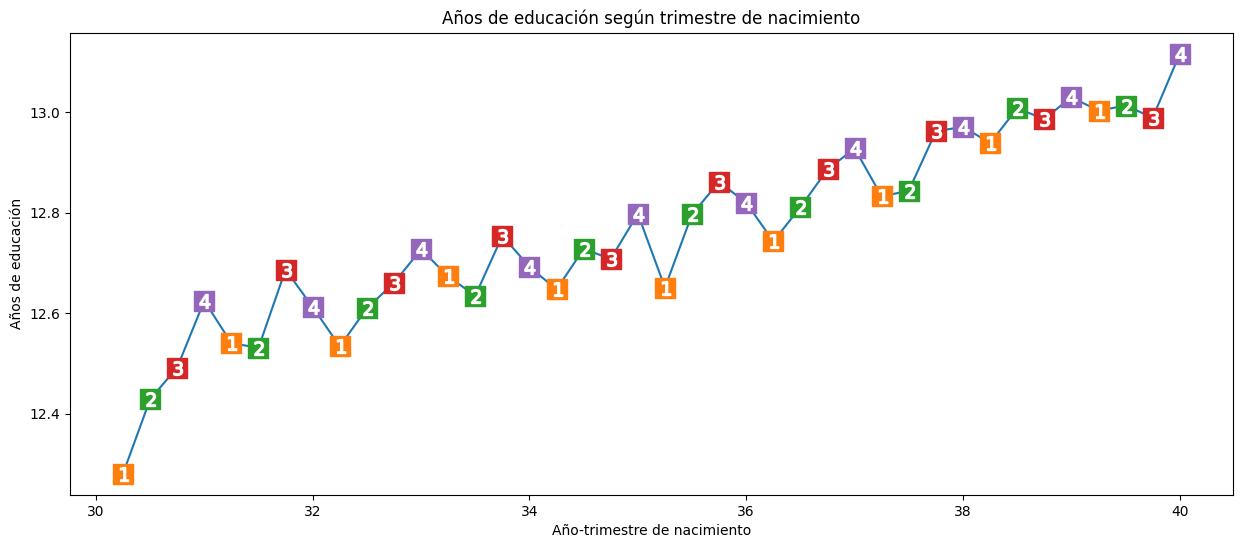

In [9]:
# Graficamos la relación entre el trimestre de nacimiento y los años de educación (una forma de mirar la relevancia!)
group_data = (ak
              .groupby(["nacim_a", "nacim_trim"])
              [["log_salario", "educ"]]
              .mean()
              .reset_index()
              .assign(nacim_a_trim = lambda d: d["nacim_a"] + (d["nacim_trim"])/4))

plt.figure(figsize=(15,6))
plt.plot(group_data["nacim_a_trim"], group_data["educ"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"nacim_trim=={q}")["nacim_a_trim"]
    y = group_data.query(f"nacim_trim=={q}")["educ"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Años de educación según trimestre de nacimiento")
plt.xlabel("Año-trimestre de nacimiento")
plt.ylabel("Años de educación");

In [10]:
# Creamos la variable binaria

ak["t4"] = [(x == 4)*1 for x in ak.nacim_trim] 

pd.crosstab(ak.nacim_trim, ak.t4)

t4,0,1
nacim_trim,,
1.0,81671,0
2.0,80138,0
3.0,86856,0
4.0,0,80844


In [11]:
# Estimamos la primera etapa
etapa1 = smf.ols("educ ~  1 + t4", data=ak).fit()

print("estimador del parámetro de t4 ", etapa1.params["t4"])
print("p-valor del parámetro de t4: ", etapa1.pvalues["t4"])

estimador del parámetro de t4  0.09212085888803544
p-valor del parámetro de t4:  4.068881965810609e-12


¡La primera etapa sirve para testear la relevancia del instrumento! Acá vemos que nacer en el cuarto trimestre tiene una correlación positiva y significativa (el p-valor es casi cero) con los años de educación.

La segunda condición, la validez, no la podemos testear, es nuestro supuesto de identificación.


Estimemos la segunda etapa:

Primero debemos obtener $\hat{educ}$, las predicciones de los años de educación usando el instrumento, a partir de la regresión que hicimos en la primera etapa:

In [12]:
# Los valores predichos para educ
ak["educfit"] = etapa1.fittedvalues

In [13]:
# Estimamos la segunda etapa:
etapa2 = smf.ols("log_salario ~ 1+ educfit",
                     data = ak).fit()

etapa2.params["educfit"]

0.0739589287518296

In [14]:
# Estimamos la forma reducida (regresar salarios en el cuarto trimestre de nacimiento)
reducida = smf.ols("log_salario ~ 1 + t4", data=ak).fit()

print("estimación: ", reducida.params["t4"])

estimación:  0.006813160039076532


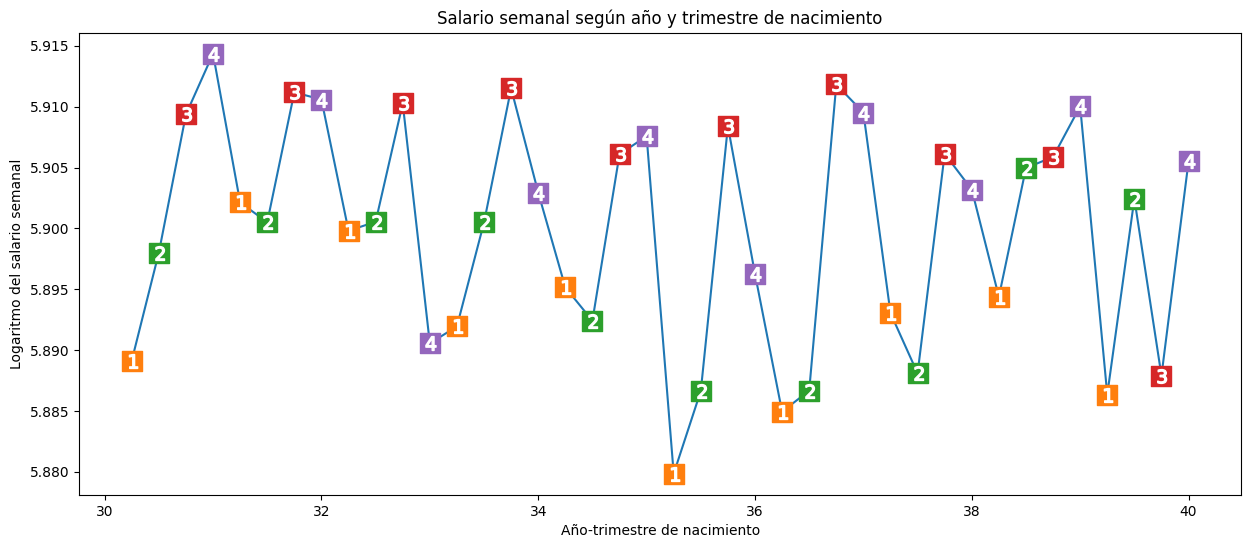

In [15]:
# Graficamos la forma reducida

plt.figure(figsize=(15,6))
plt.plot(group_data["nacim_a_trim"], group_data["log_salario"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"nacim_trim=={q}")["nacim_a_trim"]
    y = group_data.query(f"nacim_trim=={q}")["log_salario"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Salario semanal según año y trimestre de nacimiento")
plt.xlabel("Año-trimestre de nacimiento")
plt.ylabel("Logaritmo del salario semanal");

### Experimentos como instrumentos, _cumplidores_ y _no-cumplidores_

En verdad, encontrar instrumentos en variables observacionales como el de Angrist y Krueguer es realmente complicado, en el sentido de realmente poder afirmar que se cumple el supuesto de validez. Ahora bien, variables instrumentales tiene un uso súper extendido como un método combinable con experimentos y sorteos, para solucionar un problema muuuy común que tienen los experimentos: el cumplimiento parcial o _partial compliance_.

Muchas veces las personas no cumplen con el tratamiento asignado. Podemos separar a las personas en 4 grupos:

* Cumplidores (_compliers_): si les toca tratamiento cumplen con el tratamiento, si les toca control cumplen con control.
* Los que siempre se tratan (_always takers_): no importa que les toque, se van a tratar.
* Los que nunca se trata (_never takers_): no importa que les toque, nunca se tratan.
* Desafiantes (_defiers_): hacen lo contrario a lo que les toca. Asumiremos que no los hay.

Esto implica que la asignación aleatoria no elimina completamente el problema de selección, hay una parte de las personas tratadas que eligen tratarse y eso probablemente significa que tienen características distintas a las que cumple o a las que eligen no hacerlo que pueden influir sobre el resultado.

Se generan dos variables que son diferentes entre sí:
* Aquellos que por sorteo o asignación aleatoria deberían haberse tratado (aquellos con "intención de ser tratados" o "_intention to treat_"). Es decir, lo que les tocó en el sorteo. ASIGNACION
* Los que efectivamente reciben tratamiento. Y esta es la variable que interesa medir. TRATAM EFECTIVO


#### _La colimba y el crimen_

Un ejemplo de Argentina con el que van a trabajar en la práctica es el trabajo de [Galiani, Rossi, & Schargrodsky (2011). Conscription and crime...](https://www.povertyactionlab.org/sites/default/files/research-paper/227_348%20Military%20conscription%20and%20crime%20in%20Argentina%20AER%20Apr%202011.pdf). Los autores quieren ver si ir a la colimba aumenta las chances de cometer un crimen luego. Para poder identificar ese efecto aprovechan los sorteos anuales que se hacían para determinar quiénes debían cumplir con el servicio militar. Primero, se asignaba un número para cada grupo de personas de la cohorte correspondiente a ese año que tengan el DNI terminado en los mismos tres dígitos. Más tarde se anunciaba un número de corte y aquellos con número por encima debían hacer el servicio militar. Además, debían pasar un examen médico para poder hacerlo.

**Ejercicio de lectura activa**: si se sorteaba la participación en el servicio militar, ¿cuál es el problema de regresar directamente el crimen en una variable indicadora de si la persona participa o no en el servicio militar? 

**Respuesta**. 

El problema es que no todas las personas hacen lo que el sorteo indica. Para empezar, hay personas que deciden participar del servicio militar independientemente del sorteo (_always takers_). En segundo lugar, los autores muestran en su trabajo que los datos sugieren que muchos hacían "trampa" en el examen médico para intentar zafar del servicio militar (_never takers_). Cuanto más cerca del corte, más enfermedades se registraban. 

Es probable que las personas que decidan por motus propia participar del servicio militar tengan características distintas a las personas que quieren evitar el servicio militar de cualquier modo. , Entonces, es probable que el promedio de las características de los tratados (los que _efectivamente_ van al servicio militar) sean distintas al promedio de las características de los no tratados (los que no van).

Entonces, podemos usar **el sorteo para instrumentar el tratamiento**, es decir, salir sorteado con número bajo como instrumento de participar en el servicio militar.

El sorteo cumple con ambas condiciones para ser instrumento:
* Relevancia: si en efecto buena parte de los sorteados son cumplidores, salir sorteado estará positivamente correlacionado con asistir al servicio militar. 
* Validez: salir sorteado sólo afecta al crimen posterior a través de la participación en el servicio militar. Como la asignación es aleatoria, lo único que cambia en promedio entre los sorteados y no sorteados es tener que hacer el servicio militar, de modo que sólo debería afectar al crimen por esa vía.

Entonces, si usamos el sorteo como instrumento de asistir al servicio militar:

* La **forma reducida** estima la **intención de ser tratado** (o ITT, por _intention to treat_) y es el **umbral inferior** del efecto de tratamiento. ¿Por qué el umbral inferior? Si todos los que salen sorteados son cumplidores,entonces la estimación de la primera etapa será 1 y la forma reducida estima el efecto de tratamiento. Si solamente algunos son cumplidores, entonces esa estimación será menor a 1, y por ende el efecto de tratamiento será mayor a la forma areducida. Si cuando algunos sorteados se tratan hay efecto, ¡mayor sería si todos se trataran!

* Variables instrumentales identifica el LATE: el impacto del tratamiento para el **subconjunto de cumplidores**, es decir para los que se tratan por haber sido asignados a tratamiento y no por otro motivo, como los _always takers_ o _never takers_. El sorteo no nos permite ver qué sucede con ellos.

* ¿Cuál es el efecto causal de la colimba en el crimen? Resolver la práctica para enterarse.